In [1]:
import cv2
import numpy as np
import os
import math as m
import re
import pandas as pd
import scipy
from scipy.stats import skew
from scipy.stats import kurtosis
import mahotas
from skimage.feature import local_binary_pattern
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
polygons = {}

In [3]:

def gauss(vertices):
    n = len(vertices)
    area = 0.0

    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        area += x1 * y2 - x2 * y1

    area = abs(area) / 2

    return area

def perimeter_calc(vertices):
    n = len(vertices)

    perimeter = 0.0

    for i in range(n):
        x1, y1 = vertices[i]
        x2, y2 = vertices[(i + 1) % n]
        perimeter += m.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return perimeter

def calculate_roundness(vertices):
    area = gauss(vertices)
    perimeter = perimeter_calc(vertices)

    roundness = 4 * m.pi * area / perimeter ** 2

    return "{:.4f}".format(roundness)

def compute_color_moments(vertices, img):

    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)

    #polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    masked_image = cv2.bitwise_and(img, mask)
    gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    average_color = cv2.mean(masked_image, mask=gray_mask)
    #BGRg
    #blue green red (gray/neutral)

    std_dev = np.std(masked_image)
    skewnessval = scipy.stats.skew(masked_image.flatten())
    kurt = kurtosis(masked_image.flatten())



    #print("Average color:", average_color)
    #print("std dev", std_dev)
    #print("skewness", skewnessval)
    #print("kurtosis", kurt)


    return average_color, std_dev, skewnessval, kurt
    ####

    '''
    
    imagepoly = img.copy()
    average_mask = img.copy()


    cv2.polylines(imagepoly, [polygon], True, (0, 255, 0), thickness=2)

    cv2.fillPoly(average_mask, [polygon], average_color)

    horizontal1 = np.hstack((img, imagepoly))
    horizontal2 = np.hstack((masked_image, average_mask))

    vertical = np.vstack((horizontal1, horizontal2))

    

    cv2.imshow("Image", vertical)



    cv2.waitKey(0)
    cv2.destroyAllWindows()

    '''



def compute_Zernike(vertices, img):
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    zernike_moments = mahotas.features.zernike(gray_mask, radius=100, degree=8, cm=(100, 100))
    return zernike_moments.tolist()

def compute_LBP(vertices, img):
    #local binary patterns for texture
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    lbp = local_binary_pattern(gray_mask, P=8, R=1, method='uniform')

    hist, _ = np.histogram(lbp, bins=np.arange(0, 11), density=True)

    #print("LBP Histogram:", hist)
    return hist.tolist()

def compute_HUMoments(vertices, img):
    vertices = np.array(vertices)
    polygon = vertices.reshape((-1,1,2)).astype(np.int32)
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [polygon], (255,255,255))
    
    masked_image = cv2.bitwise_and(img, mask)

    gray_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

    moments = cv2.moments(gray_mask)

    hu_moments = cv2.HuMoments(moments).flatten()

    #print("Hu Moments:", hu_moments)
    for i in range(0,7):
        hu_moments[i] = -1* m.copysign(1.0, hu_moments[i]) * m.log10(abs(hu_moments[i]))

    
    return hu_moments.tolist()

    
def get_square(vertices, img):
    maxx = -1
    maxy = -1
    minx = 99999
    miny = 99999
    for v in vertices:
        maxx = max(maxx, v[0])
        maxy = max(maxy, v[1])
        minx = min(minx, v[0])
        miny = min(miny, v[1])

    p1 = [minx, miny]
    p2 = [maxx, miny]
    p3 = [maxx, maxy]
    p4 = [minx, maxy]

    return np.asarray([p1, p2, p3, p4]), img[miny:maxy, minx:maxx]

# Retrieving features

This section receives the directory of the images and a directory containing the polygons that describe the form of each fruit

In [4]:
from ultralytics import YOLO

yolomodel = YOLO('yolov8Raspberries.pt')




In [5]:
import cv2
import numpy as np
import os
import re
#"/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images"
image_dir = "/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images"
annotation_dir = "/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/labels"


regexpattern = r"^\d+"

for image_file in os.listdir(image_dir):
    #print(image_file)
    if image_file.endswith(".jpg"):
        image_path = os.path.join(image_dir, image_file)

        image = cv2.imread(image_path)



        # Predict with the model
        results = yolomodel(image_path)
        points = results[0].masks.xy[0]  # Masks object

        #print("these are the points:",points)
        #print(results[0])

        #results[0].names['0'] = "Raspberry"
        
        #cv2.imshow("result", )
        #print(image.shape)

  
        
        annotation_file = os.path.splitext(image_file)[0] + ".txt"
        imageID = re.search(regexpattern, annotation_file).group(0)
        #print(imageID)
        #print(annotation_file)

        points = np.array(points).reshape((-1, 2)).astype(np.int32)
        #print(gauss(points))
        
        mean, stddev, skewnessval, kurt = compute_color_moments(points.tolist(), image)

        humoments = compute_HUMoments(points.tolist(), image)
        square, croppedimg = get_square(points.tolist(), image)


        zernike = compute_Zernike(points.tolist(), image)

        localBinaryPatterns = compute_LBP(points.tolist(), image)
        
        #print(mean, stddev, skewnessval, kurt, humoments, zernike)
        polygons[imageID] = {"coordinates" : points.tolist(), 
                                "area" : gauss(points), 
                                "roundness" : calculate_roundness(points), 
                                "meancolor" : mean,
                                "meanB" : mean[0],
                                "meanG" : mean[1],
                                "meanR" : mean[2],
                                "meangray" : mean[3],

                                "stddev" : stddev,
                                "skewness" : skewnessval,
                                "kurtosis" : kurt,
                                "h0" : humoments[0],
                                "h1" : humoments[1],
                                "h2" : humoments[2],
                                "h3" : humoments[3],
                                "h4" : humoments[4],
                                "h5" : humoments[5],
                                "h6" : humoments[6],
                                "square" : cv2.resize(croppedimg, dsize=(140, 140), interpolation=cv2.INTER_CUBIC),

                                "zernike" : zernike,
                                "LBP" : localBinaryPatterns
                                }
        

     


image 1/1 /Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images/469_jpg.rf.e078e5b2acf969239a7c1ba7ea02d7aa.jpg: 512x512 1 0, 229.3ms
Speed: 1.4ms preprocess, 229.3ms inference, 9.6ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images/120_jpg.rf.eb10750fee85427224ddf00689b5d8ea.jpg: 512x512 1 0, 163.3ms
Speed: 0.3ms preprocess, 163.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images/200_jpg.rf.5d57295dde23bf8b2721ca315610c98f.jpg: 512x512 1 0, 147.7ms
Speed: 0.3ms preprocess, 147.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images/316_jpg.rf.db908a4a9fa6a215936076144a80b4d6.jpg: 512x512 1 0, 143.9ms
Speed: 0.3ms preprocess, 143.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /Users/pablo/Desktop/Frutas/R

# Mosaico para comparar

In [6]:
'''
import cv2
import numpy as np
import os
import re
#"/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images"
image_dir = "/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images"
annotation_dir = "/Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/labels"


regexpattern = r"^\d+"

for image_file in os.listdir(image_dir):
    #print(image_file)
    if image_file.endswith(".jpg"):
        image_path = os.path.join(image_dir, image_file)

        image = cv2.imread(image_path)

        image_path = os.path.join(image_dir, image_file)
        annotation_file = os.path.splitext(image_file)[0] + ".txt"

        annotation_path = os.path.join(annotation_dir, annotation_file)
        #print(annotation_path)
        with open(annotation_path, "r") as f:
            annotations = f.readlines()
            #print(annotations)
        annotatedPoints = []
        for annotation in annotations:
            # Split the annotation into its components
            components = annotation.split()
            class_id = int(components[0])
            coords = []

            for i in range(1, len(components)):
                corrected = 0
                if(i%2 == 0):
                    corrected = float(components[i]) * image.shape[0] 
                else:
                    corrected = float(components[i]) * image.shape[1]
                coords.append(corrected)

            annotatedPoints = np.array(coords).reshape((-1, 2)).astype(np.int32)
        # Predict with the model
        results = yolomodel(image_path)
        points = results[0].masks.xy[0]  # Masks object

        #print("these are the points:",points)
        #print(results[0])

        #results[0].names['0'] = "Raspberry"
        
        #cv2.imshow("result", )
        #print(image.shape)

  
        
        annotation_file = os.path.splitext(image_file)[0] + ".txt"
        imageID = re.search(regexpattern, annotation_file).group(0)
        #print(imageID)
        #print(annotation_file)

        points = np.array(points).reshape((-1, 2)).astype(np.int32)
        #print(gauss(points))
        
        mean, stddev, skewnessval, kurt = compute_color_moments(points.tolist(), image)

        humoments = compute_HUMoments(points.tolist(), image)


        zernike = compute_Zernike(points.tolist(), image)

        localBinaryPatterns = compute_LBP(points.tolist(), image)
        
        #print(mean, stddev, skewnessval, kurt, humoments, zernike)
        polygons[imageID] = {"coordinates" : points.tolist(), 
                                "area" : gauss(points), 
                                "roundness" : calculate_roundness(points), 
                                "meancolor" : mean,
                                "meanB" : mean[0],
                                "meanG" : mean[1],
                                "meanR" : mean[2],
                                "meangray" : mean[3],

                                "stddev" : stddev,
                                "skewness" : skewnessval,
                                "kurtosis" : kurt,
                                "h0" : humoments[0],
                                "h1" : humoments[1],
                                "h2" : humoments[2],
                                "h3" : humoments[3],
                                "h4" : humoments[4],
                                "h5" : humoments[5],
                                "h6" : humoments[6],
                                "zernike" : zernike,
                                "LBP" : localBinaryPatterns
                                }
        
        origImage = image.copy()
        annotatedOrigImage = image.copy()

        
        cv2.polylines(image, [points], True, (0, 255, 0), thickness=2)
        cv2.polylines(annotatedOrigImage, [annotatedPoints], True, (0, 255, 0), thickness=2)


        horizontal = np.hstack((results[0].plot(), image))
        horizontal2 = np.hstack((origImage, annotatedOrigImage))
        full = np.vstack((horizontal, horizontal2))


        cv2.imshow("Image", full)
        cv2.waitKey(0)
        #cv2.destroyAllWindows()
'''


image 1/1 /Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images/469_jpg.rf.e078e5b2acf969239a7c1ba7ea02d7aa.jpg: 512x512 1 0, 185.9ms
Speed: 0.8ms preprocess, 185.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images/120_jpg.rf.eb10750fee85427224ddf00689b5d8ea.jpg: 512x512 1 0, 188.8ms
Speed: 0.6ms preprocess, 188.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images/200_jpg.rf.5d57295dde23bf8b2721ca315610c98f.jpg: 512x512 1 0, 152.8ms
Speed: 0.6ms preprocess, 152.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /Users/pablo/Desktop/Frutas/RaspsSSI.v1i.yolov8/train/images/316_jpg.rf.db908a4a9fa6a215936076144a80b4d6.jpg: 512x512 1 0, 154.8ms
Speed: 0.5ms preprocess, 154.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 512)

image 1/1 /Users/pablo/Desktop/Frutas/R

In [6]:
IDAndArea = {}
IDAndCoordinates = {}
IDAndRoundness = {}

IDAndMeanColor = {}
IDAndMeanB = {}
IDAndMeanG = {}
IDAndMeanR = {}
IDAndMeanGray = {}
 
IDAndSTDDev = {}
IDAndSkewness = {}
IDAndKurtosis = {}

IDAndHUMoments = {}
IDAndHus = {}
IDAndH0 = {}
IDAndH1 = {}
IDAndH2 = {}
IDAndH3 = {}
IDAndH4 = {}
IDAndH5 = {}
IDAndH6 = {}
IDAndSquare = {}

IDAndZernike = {}
IDAndLBP = {}

for elem in polygons:
    IDAndArea[elem] = polygons[elem]["area"]


    IDAndCoordinates[elem] = polygons[elem]["coordinates"]


    IDAndRoundness[elem] = polygons[elem]["roundness"]


    IDAndMeanColor[elem] = polygons[elem]["meancolor"]


    IDAndMeanB[elem] = polygons[elem]["meanB"]

    IDAndMeanG[elem] = polygons[elem]["meanG"]

    IDAndMeanR[elem] = polygons[elem]["meanR"]

    IDAndMeanGray[elem] = polygons[elem]["meangray"]


    IDAndSTDDev[elem] = polygons[elem]["stddev"]


    IDAndSkewness[elem] = polygons[elem]["skewness"]


    IDAndKurtosis[elem] = polygons[elem]["kurtosis"]



    IDAndH0[elem] = polygons[elem]['h0']

    IDAndH1[elem] = polygons[elem]['h1']

    IDAndH2[elem] = polygons[elem]['h2']

    IDAndH3[elem] = polygons[elem]['h3']

    IDAndH4[elem] = polygons[elem]['h4']

    IDAndH5[elem] = polygons[elem]['h5']

    IDAndH6[elem] = polygons[elem]['h6']
    IDAndSquare[elem] = polygons[elem]['square']



    IDAndZernike[elem] = polygons[elem]["zernike"]


    IDAndLBP[elem] = polygons[elem]["LBP"]

'''
print(IDAndArea)
print(IDAndCoordinates)
print(IDAndRoundness)
print(IDAndMeanColor)


print(IDAndSTDDev)
print(IDAndSkewness)
print(IDAndKurtosis)

print("h0",IDAndH0)
print("h1",IDAndH1)
print("h2",IDAndH2)
print("h3",IDAndH3)
print("h4",IDAndH4)
print("h5",IDAndH5)
print("h6",IDAndH6)

print("B",IDAndMeanB)
print("G",IDAndMeanG)
print("R",IDAndMeanR)
print("Gray",IDAndMeanGray)
'''
#print(IDAndZernike)
#print(IDAndLBP)


'\nprint(IDAndArea)\nprint(IDAndCoordinates)\nprint(IDAndRoundness)\nprint(IDAndMeanColor)\n\n\nprint(IDAndSTDDev)\nprint(IDAndSkewness)\nprint(IDAndKurtosis)\n\nprint("h0",IDAndH0)\nprint("h1",IDAndH1)\nprint("h2",IDAndH2)\nprint("h3",IDAndH3)\nprint("h4",IDAndH4)\nprint("h5",IDAndH5)\nprint("h6",IDAndH6)\n\nprint("B",IDAndMeanB)\nprint("G",IDAndMeanG)\nprint("R",IDAndMeanR)\nprint("Gray",IDAndMeanGray)\n'

# Area

In [7]:
areadf = pd.Series(IDAndArea).to_frame().reset_index()
areadf.columns = ['ID', 'AreaInSquaredPixels']
areadf['ID'] = areadf['ID'].astype(int)
areadf['AreaInSquaredPixels'] = areadf['AreaInSquaredPixels'].astype(float)


areadf = areadf.sort_values('ID')
areadf = areadf.reset_index(drop=True)

areadf.head(10)



,ID,AreaInSquaredPixels
0,1,19512.5
1,2,19716.0
2,3,19595.5
3,4,19770.5
4,5,19784.0
5,6,24356.0
6,7,24210.0
7,8,22636.0
8,9,23844.5
9,10,22978.5


# Roundness

In [8]:
roundnessdf = pd.Series(IDAndRoundness).to_frame().reset_index()
roundnessdf.columns = ['ID', 'Roundness']
roundnessdf['ID'] = roundnessdf['ID'].astype(int)
roundnessdf['Roundness'] = roundnessdf['Roundness'].astype(float)


roundnessdf = roundnessdf.sort_values('ID')
roundnessdf = roundnessdf.reset_index(drop=True)

roundnessdf.head(10)



,ID,Roundness
0,1,0.8571
1,2,0.8673
2,3,0.8522
3,4,0.8534
4,5,0.8649
5,6,0.7994
6,7,0.7965
7,8,0.7820
8,9,0.7846
9,10,0.7941


# Mass

In [7]:
def calculate_average_mass(df_row):
    sum_of_weights = 0

    for i in range(1,len(df_row)):
        sum_of_weights += float(df_row[i])
        average = sum_of_weights / (len(df_row) - 1)
    return "{:.4f}".format(average)

def rename_image(df_row):
    return df_row['Image'][8:]

def get_index(df_row):
    return df_row['Image'][:len(df_row['Image']) - 4]

In [8]:
weightsFileName = '/Users/pablo/Desktop/Frutas/weightsRaspberries/weightsRaspberries.txt'

df = pd.read_csv(weightsFileName, header=None, delim_whitespace=True)

df.rename(columns = {0:'Image'}, 
            inplace = True)

df['AverageMass'] = df.apply(calculate_average_mass, axis=1)

df['Image'] = df.apply(rename_image, axis=1)

df['ID'] = df.apply(get_index, axis=1)

mass = pd.DataFrame().assign(Image=df['Image'], ID=df['ID'], 
                            Weigh1=df[1],
                            Weigh2=df[2],
                            Weigh3=df[3],
                            Weigh4=df[4],
                            Weigh5=df[5],
                            Weigh6=df[6],
                            Weigh7=df[7],
                            Weigh8=df[8],
                            Weigh9=df[9],
                            Weigh10=df[10],
                            Weigh11=df[11],
                            AverageMass=df['AverageMass'])
mass['ID'] = mass['ID'].astype(int)
mass['AverageMass'] = mass['AverageMass'].astype(float)
mass.to_json('mass.json', orient = 'split', compression = 'infer', index = 'true')
mass.head(10)
latex_table = mass.head(10).to_latex(index=False, bold_rows=True, caption="Table of image Weighs and Average Mass")

#print(latex_table)


# Classic Geometry

In [11]:
classicgeometry = pd.merge(areadf[['ID', 'AreaInSquaredPixels']], mass[['ID', 'AverageMass']], on='ID', how='inner')

classicgeometry = pd.merge(classicgeometry[['ID', 'AverageMass', 'AreaInSquaredPixels']], roundnessdf[['ID', 'Roundness']], on='ID', how='inner')

classicgeometry.to_csv('classicgeometryYOLORasp.csv', index = False)

classicgeometry.head(5)

#print(latex_table)

,ID,AverageMass,AreaInSquaredPixels,Roundness
0,1,4.8566,19512.5,0.8571
1,2,4.8568,19716.0,0.8673
2,3,4.8654,19595.5,0.8522
3,4,4.8691,19770.5,0.8534
4,5,4.8689,19784.0,0.8649


# Hu Moments

In [12]:
hu0 = pd.Series(IDAndH0).to_frame().reset_index()
hu0.columns = ['ID', 'hu0']
hu0['ID'] = hu0['ID'].astype(int)
hu0['hu0'] = hu0['hu0'].astype(float)
hu0 = hu0.sort_values('ID')
hu0 = hu0.reset_index(drop=True)

#print(hu0.head(10))

hu1 = pd.Series(IDAndH1).to_frame().reset_index()
hu1.columns = ['ID', 'hu1']
hu1['ID'] = hu1['ID'].astype(int)
hu1['hu1'] = hu1['hu1'].astype(float)
hu1 = hu1.sort_values('ID')
hu1 = hu1.reset_index(drop=True)

#print(hu1.head(10))

hu2 = pd.Series(IDAndH2).to_frame().reset_index()
hu2.columns = ['ID', 'hu2']
hu2['ID'] = hu2['ID'].astype(int)
hu2['hu2'] = hu2['hu2'].astype(float)
hu2 = hu2.sort_values('ID')
hu2 = hu2.reset_index(drop=True)

#print(hu2.head(10))

hu3 = pd.Series(IDAndH2).to_frame().reset_index()
hu3.columns = ['ID', 'hu3']
hu3['ID'] = hu3['ID'].astype(int)
hu3['hu3'] = hu3['hu3'].astype(float)
hu3 = hu3.sort_values('ID')
hu3 = hu3.reset_index(drop=True)

#print(hu3.head(10))

hu4 = pd.Series(IDAndH4).to_frame().reset_index()
hu4.columns = ['ID', 'hu4']
hu4['ID'] = hu4['ID'].astype(int)
hu4['hu4'] = hu4['hu4'].astype(float)
hu4 = hu4.sort_values('ID')
hu4 = hu4.reset_index(drop=True)

#print(hu4.head(10))


hu5 = pd.Series(IDAndH5).to_frame().reset_index()
hu5.columns = ['ID', 'hu5']
hu5['ID'] = hu5['ID'].astype(int)
hu5['hu5'] = hu5['hu5'].astype(float)
hu5 = hu5.sort_values('ID')
hu5 = hu5.reset_index(drop=True)

#print(hu5.head(10))


hu6 = pd.Series(IDAndH6).to_frame().reset_index()
hu6.columns = ['ID', 'hu6']
hu6['ID'] = hu6['ID'].astype(int)
hu6['hu6'] = hu6['hu6'].astype(float)
hu6 = hu6.sort_values('ID')
hu6 = hu6.reset_index(drop=True)

#print(hu6.head(10))
humoments = pd.merge(hu0[['ID', 'hu0']], mass[['ID', 'AverageMass']], on='ID', how='inner')

humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0']], hu1[['ID', 'hu1']], on='ID', how='inner')

humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1']], hu2[['ID', 'hu2']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2']], hu3[['ID', 'hu3']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2', 'hu3']], hu4[['ID', 'hu4']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4']], hu5[['ID', 'hu5']], on='ID', how='inner')
humoments = pd.merge(humoments[['ID', 'AverageMass', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5']], hu6[['ID', 'hu6']], on='ID', how='inner')


humoments.to_csv('humomentsYOLORasp.csv', index = False)

humoments.head(5)
#
#0	1	2	3	4	5	6
#469	2.669828	6.950577	10.427229	10.260607	-20.705395	-13.776959	20.819507
#humoments.loc[468]

#print(latex_table)

,ID,AverageMass,hu0,hu1,hu2,hu3,hu4,hu5,hu6
0,1,4.8566,2.673033,7.010661,10.229825,10.229825,21.852097,15.126325,22.082975
1,2,4.8568,2.645191,6.989123,9.823755,9.823755,-20.681373,14.374104,-20.827661
2,3,4.8654,2.661717,6.901214,10.126616,10.126616,-21.688223,-15.053662,-20.861062
3,4,4.8691,2.679435,7.465285,10.078639,10.078639,-22.324437,14.268356,20.842234
4,5,4.8689,2.657988,7.188936,9.928998,9.928998,-22.088880,-14.932566,-22.112530


# Color

In [15]:
meanB = pd.Series(IDAndMeanB).to_frame().reset_index()
meanB.columns = ['ID', 'meanB']
meanB['ID'] = meanB['ID'].astype(int)
meanB['meanB'] = meanB['meanB'].astype(float)
meanB = meanB.sort_values('ID')
meanB = meanB.reset_index(drop=True)

#print(meanB.head(10))

meanG = pd.Series(IDAndMeanG).to_frame().reset_index()
meanG.columns = ['ID', 'meanG']
meanG['ID'] = meanG['ID'].astype(int)
meanG['meanG'] = meanG['meanG'].astype(float)
meanG = meanG.sort_values('ID')
meanG = meanG.reset_index(drop=True)

#print(meanG.head(10))

meanR = pd.Series(IDAndMeanR).to_frame().reset_index()
meanR.columns = ['ID', 'meanR']
meanR['ID'] = meanR['ID'].astype(int)
meanR['meanR'] = meanR['meanR'].astype(float)
meanR = meanR.sort_values('ID')
meanR = meanR.reset_index(drop=True)

#print(meanR.head(10))

meanGray = pd.Series(IDAndMeanGray).to_frame().reset_index()
meanGray.columns = ['ID', 'meangray']
meanGray['ID'] = meanGray['ID'].astype(int)
#meanGray['meangray'] = meanGray['meangray'].astype(float)
meanGray = meanGray.sort_values('ID')
meanGray = meanGray.reset_index(drop=True)

#print(meanGray.head(10))

colors = pd.merge(meanB[['ID', 'meanB']], mass[['ID', 'AverageMass']], on='ID', how='inner')

colors = pd.merge(colors[['ID', 'AverageMass','meanB']], meanG[['ID', 'meanG']], on='ID', how='inner')
colors = pd.merge(colors[['ID', 'AverageMass','meanB', 'meanG']], meanR[['ID', 'meanR']], on='ID', how='inner')
#colors = pd.merge(colors[['ID', 'AverageMass','meanB', 'meanG', 'meanR']], meanGray[['ID', 'meangray']], on='ID', how='inner')

colors.to_csv('colorsYOLORasp.csv', index = False)


colors.head(5)

#print(latex_table)

,ID,AverageMass,meanB,meanG,meanR
0,1,4.8566,32.859581,47.789700,158.103808
1,2,4.8568,29.388143,42.828957,151.619174
2,3,4.8654,31.607341,45.915045,155.818342
3,4,4.8691,34.260420,49.282959,159.301299
4,5,4.8689,30.567126,45.603636,154.491110


# Cropped Image

(140, 140, 3)


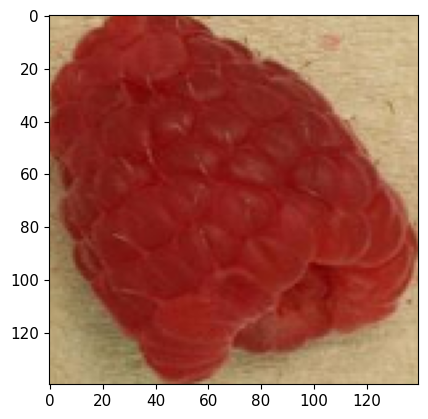

,ID,AverageMass,img
0,1,4.8566,"[[[138, 178, 203], [137, 177, 202], [137, 179,..."
1,2,4.8568,"[[[140, 184, 208], [130, 174, 198], [124, 168,..."
2,3,4.8654,"[[[140, 186, 210], [140, 186, 210], [131, 177,..."
3,4,4.8691,"[[[150, 187, 209], [146, 183, 205], [149, 186,..."
4,5,4.8689,"[[[137, 179, 202], [141, 183, 206], [144, 186,..."


In [10]:
#print(IDAndSquare)


croppedimages = pd.Series(IDAndSquare).to_frame().reset_index()
croppedimages.columns = ['ID', 'img']
croppedimages['ID'] = croppedimages['ID'].astype(int)

#croppedimages['img'] = croppedimages['img'].astype(float)


croppedimages = croppedimages.sort_values('ID')
croppedimages = croppedimages.reset_index(drop=True)

croppedimages.head(10)

#croppedimages.to_csv('croppedimagesBlueberriesRaw.csv', index = False)

###
%matplotlib inline 


crop = croppedimages.loc[50].at["img"][...,::-1]
#res = cv2.resize(crop, dsize=(140, 140), interpolation=cv2.INTER_CUBIC)


print(crop.shape)

plt.imshow(crop)
plt.show()
###


croppedimages = pd.merge(mass[['ID', 'AverageMass']], croppedimages[['ID', 'img']], on='ID', how='inner')

#croppedimages.to_csv('croppedimagesRaspberriesRaw.csv', index = False)

croppedimages.to_pickle('croppedimagesRaspberriesYOLO.pkl')

croppedimages.head(5)

#print(latex_table)


# All data

In [17]:

allfeatures = pd.merge(classicgeometry[['ID', 'AverageMass', 'AreaInSquaredPixels', 'Roundness']], humoments[['ID', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5', 'hu6']], on='ID', how='inner')
allfeatures = pd.merge(allfeatures[['ID', 'AverageMass', 'AreaInSquaredPixels', 'Roundness', 'hu0', 'hu1', 'hu2', 'hu3', 'hu4', 'hu5', 'hu6']], colors[['ID', 'meanB', 'meanG', 'meanR']], on='ID', how='inner')


allfeatures.to_csv('allfeaturesYOLORasp.csv', index = False)

allfeatures.head(5)

,ID,AverageMass,AreaInSquaredPixels,Roundness,hu0,hu1,hu2,hu3,hu4,hu5,hu6,meanB,meanG,meanR
0,1,4.8566,19512.5,0.8571,2.673033,7.010661,10.229825,10.229825,21.852097,15.126325,22.082975,32.859581,47.789700,158.103808
1,2,4.8568,19716.0,0.8673,2.645191,6.989123,9.823755,9.823755,-20.681373,14.374104,-20.827661,29.388143,42.828957,151.619174
2,3,4.8654,19595.5,0.8522,2.661717,6.901214,10.126616,10.126616,-21.688223,-15.053662,-20.861062,31.607341,45.915045,155.818342
3,4,4.8691,19770.5,0.8534,2.679435,7.465285,10.078639,10.078639,-22.324437,14.268356,20.842234,34.260420,49.282959,159.301299
4,5,4.8689,19784.0,0.8649,2.657988,7.188936,9.928998,9.928998,-22.088880,-14.932566,-22.112530,30.567126,45.603636,154.491110
